<a href="https://colab.research.google.com/github/CeciSC/LSTMEquityIndexPrediction/blob/main/sp500_RNN_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add S&P 500 and HS300

In [2]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)


2.3.0


In [3]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import time

In [5]:
from google.colab import files
uploaded = files.upload()

Saving sp500.csv to sp500.csv


# New Section

In [6]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded['sp500.csv'].decode('utf-8')))
df

,Date,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1/4/10,1132.989990,1116.560059,1133.869995,1116.560059,3991400000,1115.100000,1115.100000,1126.420000,1125.698,1121.010,1112.1640,0.647776,1.068679,8.643298,1132.999138,1086.927786,84.870356,78.846150,2.146631,9.192857,6.51,23.81,3.081232,4.616999,1.409173,0.714095,67.244306,63.214617,75.000000,1670751798,0.016043,0.014715,0.949162,0.001158,0.001489,0.013676,0.018726
1,1/5/10,1136.520020,1132.660034,1136.630005,1129.660034,2491020000,1132.989990,1115.100000,1115.100000,1127.446,1124.415,1113.6910,0.804828,1.076560,9.350417,1136.160575,1085.757887,89.747808,84.870356,3.689512,9.094286,10.04,40.44,0.497288,0.504125,1.467176,0.827135,70.122163,64.833024,83.333333,1680495719,0.003116,0.003408,0.984220,0.001553,0.001373,0.013741,0.020499
2,1/6/10,1137.140015,1135.709961,1139.189941,1133.949951,4972660000,1136.520020,1132.989990,1115.100000,1129.634,1126.724,1115.3855,0.664463,0.924450,9.847328,1138.597668,1086.832332,90.362361,89.747808,3.144757,8.842857,9.36,34.67,8.408532,8.408532,1.447810,0.972874,70.665365,65.126998,83.333333,1689649585,0.000546,0.001259,0.608792,0.001941,0.001522,0.014315,0.019504
3,1/7/10,1141.689941,1136.270020,1142.459961,1131.319946,5270680000,1137.140015,1136.520020,1132.989990,1132.688,1129.091,1117.8730,0.794747,1.115853,10.487389,1141.719120,1087.253957,92.646638,90.362361,2.481038,9.047143,15.49,27.64,2.784810,2.784810,1.516096,1.102875,74.713876,67.314440,83.333333,1700117112,0.004001,0.004770,0.930878,0.002704,0.002230,0.015513,0.021306
4,1/8/10,1144.979980,1140.520020,1145.390015,1136.219971,4389590000,1141.689941,1137.140015,1136.520020,1138.664,1131.530,1120.3245,0.554685,1.188656,11.131796,1145.406723,1086.344816,94.650843,92.646638,2.411406,8.752143,18.56,26.96,1.340746,1.422130,1.662139,1.205562,77.418091,68.855440,83.333333,1708729171,0.002882,0.003910,0.955285,0.005276,0.002193,0.018599,0.022007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,12/23/19,3224.010010,3226.050049,3227.780029,3222.300049,3060610000,3221.219971,3205.370117,3191.139893,3206.852,3183.723,3156.2565,0.535042,1.265405,33.895614,3220.180785,3072.903061,94.586116,93.872407,3.418842,18.895714,55.21,106.58,3.707346,10.258503,1.802058,0.945974,87.681299,77.928883,75.000000,2825748610,0.000866,-0.000632,0.312038,0.002035,0.001805,0.017864,0.021466
2511,12/24/19,3223.379883,3225.449951,3226.429932,3220.510010,1296540000,3224.010010,3221.219971,3205.370117,3213.024,3192.809,3160.7435,0.322313,0.957495,34.643268,3229.009425,3071.991344,94.748524,94.586116,2.462563,17.448571,31.93,77.47,4.652638,12.008734,1.841543,1.022514,86.612135,77.532657,75.000000,2824040676,-0.000195,-0.000642,0.484782,0.001925,0.001422,0.017986,0.019817
2512,12/26/19,3239.909912,3227.199951,3240.080078,3227.199951,2160680000,3223.379883,3224.010010,3221.219971,3222.778,3202.637,3165.7130,0.531591,1.163822,36.152876,3239.808064,3070.260398,96.431209,94.748524,3.428230,17.520714,48.77,107.39,0.203422,0.706861,1.941590,1.149095,90.326191,80.387020,83.333333,2827207304,0.005128,0.003938,0.986788,0.003036,0.001572,0.019627,0.023438
2513,12/27/19,3240.020020,3247.229980,3247.929932,3234.370117,2428670000,3239.909912,3223.379883,3224.010010,3229.708,3209.782,3170.0325,0.319286,0.942058,36.932393,3249.230816,3070.056107,93.520236,96.431209,3.131814,16.120000,34.65,98.39,12.301711,28.847557,2.046353,1.281760,90.347574,80.405092,83.333333,2830565850,0.000034,-0.002220,0.416665,0.002150,0.001364,0.020215,0.022078


In [7]:
df.dtypes

Date                              object
Close                            float64
Open                             float64
High                             float64
Low                              float64
Volume                             int64
x(t-1)                           float64
x(t-2)                           float64
x(t-3)                           float64
MA5                              float64
MA10                             float64
MA20                             float64
BIAS5                            float64
BIAS10                           float64
DIFF                             float64
BU                               float64
BL                               float64
KDJ                              float64
KDJ(t-1)                         float64
ROC                              float64
TR（14）                           float64
MTM6                             float64
MTM12                            float64
WR%10                            float64
WR%5            

In [8]:
df[['Volume']] = df[['Volume']].astype('float')
df[['OBV']] = df[['OBV']].astype('float')

# df_feature = df[['Close','Open','High','Low','Volume']]
# df_feature.columns = [['close','open','high','low','volume']]
# df_feature.head()
df_feature = df
df_feature = df_feature.drop(['Date'], axis=1)
df_feature.head()

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1132.989990,1116.560059,1133.869995,1116.560059,3.991400e+09,1115.100000,1115.100000,1126.42000,1125.698,1121.010,1112.1640,0.647776,1.068679,8.643298,1132.999138,1086.927786,84.870356,78.846150,2.146631,9.192857,6.51,23.81,3.081232,4.616999,1.409173,0.714095,67.244306,63.214617,75.000000,1.670752e+09,0.016043,0.014715,0.949162,0.001158,0.001489,0.013676,0.018726
1,1136.520020,1132.660034,1136.630005,1129.660034,2.491020e+09,1132.989990,1115.100000,1115.10000,1127.446,1124.415,1113.6910,0.804828,1.076560,9.350417,1136.160575,1085.757887,89.747808,84.870356,3.689512,9.094286,10.04,40.44,0.497288,0.504125,1.467176,0.827135,70.122163,64.833024,83.333333,1.680496e+09,0.003116,0.003408,0.984220,0.001553,0.001373,0.013741,0.020499
2,1137.140015,1135.709961,1139.189941,1133.949951,4.972660e+09,1136.520020,1132.989990,1115.10000,1129.634,1126.724,1115.3855,0.664463,0.924450,9.847328,1138.597668,1086.832332,90.362361,89.747808,3.144757,8.842857,9.36,34.67,8.408532,8.408532,1.447810,0.972874,70.665365,65.126998,83.333333,1.689650e+09,0.000546,0.001259,0.608792,0.001941,0.001522,0.014315,0.019504
3,1141.689941,1136.270020,1142.459961,1131.319946,5.270680e+09,1137.140015,1136.520020,1132.98999,1132.688,1129.091,1117.8730,0.794747,1.115853,10.487389,1141.719120,1087.253957,92.646638,90.362361,2.481038,9.047143,15.49,27.64,2.784810,2.784810,1.516096,1.102875,74.713876,67.314440,83.333333,1.700117e+09,0.004001,0.004770,0.930878,0.002704,0.002230,0.015513,0.021306
4,1144.979980,1140.520020,1145.390015,1136.219971,4.389590e+09,1141.689941,1137.140015,1136.52002,1138.664,1131.530,1120.3245,0.554685,1.188656,11.131796,1145.406723,1086.344816,94.650843,92.646638,2.411406,8.752143,18.56,26.96,1.340746,1.422130,1.662139,1.205562,77.418091,68.855440,83.333333,1.708729e+09,0.002882,0.003910,0.955285,0.005276,0.002193,0.018599,0.022007


In [9]:
df_feature.shape

(2515, 37)

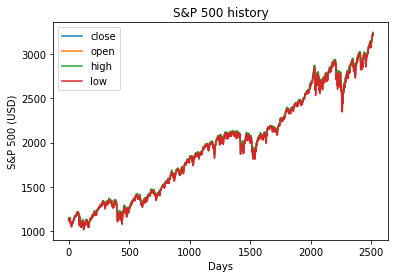

In [10]:
### EDA
plt.figure()
plt.plot(df_feature[["Close"]])
plt.plot(df_feature[["Open"]])
plt.plot(df_feature[["High"]])
plt.plot(df_feature[["Low"]])
plt.title('S&P 500 history')
plt.ylabel('S&P 500 (USD)')
plt.xlabel('Days')
plt.legend(['close', 'open','high','low'], loc='upper left')
plt.show()

In [11]:
df_feature

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1132.989990,1116.560059,1133.869995,1116.560059,3.991400e+09,1115.100000,1115.100000,1126.420000,1125.698,1121.010,1112.1640,0.647776,1.068679,8.643298,1132.999138,1086.927786,84.870356,78.846150,2.146631,9.192857,6.51,23.81,3.081232,4.616999,1.409173,0.714095,67.244306,63.214617,75.000000,1.670752e+09,0.016043,0.014715,0.949162,0.001158,0.001489,0.013676,0.018726
1,1136.520020,1132.660034,1136.630005,1129.660034,2.491020e+09,1132.989990,1115.100000,1115.100000,1127.446,1124.415,1113.6910,0.804828,1.076560,9.350417,1136.160575,1085.757887,89.747808,84.870356,3.689512,9.094286,10.04,40.44,0.497288,0.504125,1.467176,0.827135,70.122163,64.833024,83.333333,1.680496e+09,0.003116,0.003408,0.984220,0.001553,0.001373,0.013741,0.020499
2,1137.140015,1135.709961,1139.189941,1133.949951,4.972660e+09,1136.520020,1132.989990,1115.100000,1129.634,1126.724,1115.3855,0.664463,0.924450,9.847328,1138.597668,1086.832332,90.362361,89.747808,3.144757,8.842857,9.36,34.67,8.408532,8.408532,1.447810,0.972874,70.665365,65.126998,83.333333,1.689650e+09,0.000546,0.001259,0.608792,0.001941,0.001522,0.014315,0.019504
3,1141.689941,1136.270020,1142.459961,1131.319946,5.270680e+09,1137.140015,1136.520020,1132.989990,1132.688,1129.091,1117.8730,0.794747,1.115853,10.487389,1141.719120,1087.253957,92.646638,90.362361,2.481038,9.047143,15.49,27.64,2.784810,2.784810,1.516096,1.102875,74.713876,67.314440,83.333333,1.700117e+09,0.004001,0.004770,0.930878,0.002704,0.002230,0.015513,0.021306
4,1144.979980,1140.520020,1145.390015,1136.219971,4.389590e+09,1141.689941,1137.140015,1136.520020,1138.664,1131.530,1120.3245,0.554685,1.188656,11.131796,1145.406723,1086.344816,94.650843,92.646638,2.411406,8.752143,18.56,26.96,1.340746,1.422130,1.662139,1.205562,77.418091,68.855440,83.333333,1.708729e+09,0.002882,0.003910,0.955285,0.005276,0.002193,0.018599,0.022007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,3224.010010,3226.050049,3227.780029,3222.300049,3.060610e+09,3221.219971,3205.370117,3191.139893,3206.852,3183.723,3156.2565,0.535042,1.265405,33.895614,3220.180785,3072.903061,94.586116,93.872407,3.418842,18.895714,55.21,106.58,3.707346,10.258503,1.802058,0.945974,87.681299,77.928883,75.000000,2.825749e+09,0.000866,-0.000632,0.312038,0.002035,0.001805,0.017864,0.021466
2511,3223.379883,3225.449951,3226.429932,3220.510010,1.296540e+09,3224.010010,3221.219971,3205.370117,3213.024,3192.809,3160.7435,0.322313,0.957495,34.643268,3229.009425,3071.991344,94.748524,94.586116,2.462563,17.448571,31.93,77.47,4.652638,12.008734,1.841543,1.022514,86.612135,77.532657,75.000000,2.824041e+09,-0.000195,-0.000642,0.484782,0.001925,0.001422,0.017986,0.019817
2512,3239.909912,3227.199951,3240.080078,3227.199951,2.160680e+09,3223.379883,3224.010010,3221.219971,3222.778,3202.637,3165.7130,0.531591,1.163822,36.152876,3239.808064,3070.260398,96.431209,94.748524,3.428230,17.520714,48.77,107.39,0.203422,0.706861,1.941590,1.149095,90.326191,80.387020,83.333333,2.827207e+09,0.005128,0.003938,0.986788,0.003036,0.001572,0.019627,0.023438
2513,3240.020020,3247.229980,3247.929932,3234.370117,2.428670e+09,3239.909912,3223.379883,3224.010010,3229.708,3209.782,3170.0325,0.319286,0.942058,36.932393,3249.230816,3070.056107,93.520236,96.431209,3.131814,16.120000,34.65,98.39,12.301711,28.847557,2.046353,1.281760,90.347574,80.405092,83.333333,2.830566e+09,0.000034,-0.002220,0.416665,0.002150,0.001364,0.020215,0.022078


In [12]:
def get_profit_class(data):
    '''
    classify the price movement direction
    '''
    data_diff = data.diff(-next_n)
    data_diff[data_diff > 0] = 0 # price goes down
    data_diff[data_diff < 0] = 1 # price goes up
    return data_diff

next_n = 1

place_data = get_profit_class(df_feature)
df_feature['signal'] = place_data['Close']
df_feature['signal']= df_feature['signal'].shift(next_n).fillna(method='ffill').shift(-next_n).to_frame().fillna(method='ffill')
df_feature

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t),signal
0,1132.989990,1116.560059,1133.869995,1116.560059,3.991400e+09,1115.100000,1115.100000,1126.420000,1125.698,1121.010,1112.1640,0.647776,1.068679,8.643298,1132.999138,1086.927786,84.870356,78.846150,2.146631,9.192857,6.51,23.81,3.081232,4.616999,1.409173,0.714095,67.244306,63.214617,75.000000,1.670752e+09,0.016043,0.014715,0.949162,0.001158,0.001489,0.013676,0.018726,1.0
1,1136.520020,1132.660034,1136.630005,1129.660034,2.491020e+09,1132.989990,1115.100000,1115.100000,1127.446,1124.415,1113.6910,0.804828,1.076560,9.350417,1136.160575,1085.757887,89.747808,84.870356,3.689512,9.094286,10.04,40.44,0.497288,0.504125,1.467176,0.827135,70.122163,64.833024,83.333333,1.680496e+09,0.003116,0.003408,0.984220,0.001553,0.001373,0.013741,0.020499,1.0
2,1137.140015,1135.709961,1139.189941,1133.949951,4.972660e+09,1136.520020,1132.989990,1115.100000,1129.634,1126.724,1115.3855,0.664463,0.924450,9.847328,1138.597668,1086.832332,90.362361,89.747808,3.144757,8.842857,9.36,34.67,8.408532,8.408532,1.447810,0.972874,70.665365,65.126998,83.333333,1.689650e+09,0.000546,0.001259,0.608792,0.001941,0.001522,0.014315,0.019504,1.0
3,1141.689941,1136.270020,1142.459961,1131.319946,5.270680e+09,1137.140015,1136.520020,1132.989990,1132.688,1129.091,1117.8730,0.794747,1.115853,10.487389,1141.719120,1087.253957,92.646638,90.362361,2.481038,9.047143,15.49,27.64,2.784810,2.784810,1.516096,1.102875,74.713876,67.314440,83.333333,1.700117e+09,0.004001,0.004770,0.930878,0.002704,0.002230,0.015513,0.021306,1.0
4,1144.979980,1140.520020,1145.390015,1136.219971,4.389590e+09,1141.689941,1137.140015,1136.520020,1138.664,1131.530,1120.3245,0.554685,1.188656,11.131796,1145.406723,1086.344816,94.650843,92.646638,2.411406,8.752143,18.56,26.96,1.340746,1.422130,1.662139,1.205562,77.418091,68.855440,83.333333,1.708729e+09,0.002882,0.003910,0.955285,0.005276,0.002193,0.018599,0.022007,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,3224.010010,3226.050049,3227.780029,3222.300049,3.060610e+09,3221.219971,3205.370117,3191.139893,3206.852,3183.723,3156.2565,0.535042,1.265405,33.895614,3220.180785,3072.903061,94.586116,93.872407,3.418842,18.895714,55.21,106.58,3.707346,10.258503,1.802058,0.945974,87.681299,77.928883,75.000000,2.825749e+09,0.000866,-0.000632,0.312038,0.002035,0.001805,0.017864,0.021466,0.0
2511,3223.379883,3225.449951,3226.429932,3220.510010,1.296540e+09,3224.010010,3221.219971,3205.370117,3213.024,3192.809,3160.7435,0.322313,0.957495,34.643268,3229.009425,3071.991344,94.748524,94.586116,2.462563,17.448571,31.93,77.47,4.652638,12.008734,1.841543,1.022514,86.612135,77.532657,75.000000,2.824041e+09,-0.000195,-0.000642,0.484782,0.001925,0.001422,0.017986,0.019817,1.0
2512,3239.909912,3227.199951,3240.080078,3227.199951,2.160680e+09,3223.379883,3224.010010,3221.219971,3222.778,3202.637,3165.7130,0.531591,1.163822,36.152876,3239.808064,3070.260398,96.431209,94.748524,3.428230,17.520714,48.77,107.39,0.203422,0.706861,1.941590,1.149095,90.326191,80.387020,83.333333,2.827207e+09,0.005128,0.003938,0.986788,0.003036,0.001572,0.019627,0.023438,1.0
2513,3240.020020,3247.229980,3247.929932,3234.370117,2.428670e+09,3239.909912,3223.379883,3224.010010,3229.708,3209.782,3170.0325,0.319286,0.942058,36.932393,3249.230816,3070.056107,93.520236,96.431209,3.131814,16.120000,34.65,98.39,12.301711,28.847557,2.046353,1.281760,90.347574,80.405092,83.333333,2.830566e+09,0.000034,-0.002220,0.416665,0.002150,0.001364,0.020215,0.022078,0.0


In [13]:
data_train = df_feature.iloc[:2013, :]
data_test = df_feature.iloc[2013:, :]
print(data_train.shape, data_test.shape)

(2013, 38) (502, 38)


In [14]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(data_train)

# apply transformation to training data
train = scaler.transform(data_train)

# apply same transformation to test data
test = scaler.transform(data_test)

In [15]:
test

array([[1.00338823, 0.99460681, 1.0005535 , ..., 0.69556862, 0.69649564,
        1.        ],
       [1.01373256, 1.00308706, 1.01167263, ..., 0.70541557, 0.72122419,
        1.        ],
       [1.02028693, 1.01597546, 1.02064961, ..., 0.7171777 , 0.73241612,
        1.        ],
       ...,
       [1.32966936, 1.32100345, 1.32798047, ..., 0.77989024, 0.75821107,
        1.        ],
       [1.32973539, 1.33303307, 1.33270355, ..., 0.78394371, 0.75157323,
        0.        ],
       [1.31850356, 1.328745  , 1.32848579, ..., 0.77439877, 0.71645595,
        0.        ]])

In [16]:
# y train/test: numeric labels, for regression 
y_train = np.array(df_feature.iloc[:2013, 0])
y_test = np.array(df_feature.iloc[2013:, 0])
print(y_train.shape, y_test.shape)

(2013,) (502,)


In [17]:
past_steps = 15
next_steps = 1

In [18]:
X_train = train[:,:-1]
X_test = test[:,:-1]
y_train = train[:,-1]
y_test = test[:,-1]

In [19]:
X_train = np.array([X_train[i : i + past_steps, :] for i in range(0, X_train.shape[0] - (next_steps+ past_steps),1)])
X_test = np.array([X_test[i : i + past_steps, :] for i in range(0, X_test.shape[0] - (next_steps+ past_steps),1)])

In [20]:
X_train.shape

(1997, 15, 37)

In [21]:
y_train_regression = np.array([y_train[i + past_steps + next_steps] for i in range(0,train.shape[0] - (next_steps+ past_steps),1)])
y_test_regression = np.array([y_test[i + past_steps + next_steps] for i in range(0,test.shape[0] - (next_steps+ past_steps),1)])

In [22]:
y_train_regression.shape

(1997,)

In [24]:
ret = df.iloc[2030:, :]
ret = ret['return']
ret

2030    0.011841
2031   -0.006732
2032   -0.010899
2033    0.000489
2034   -0.000648
          ...   
2510    0.000866
2511   -0.000195
2512    0.005128
2513    0.000034
2514   -0.005781
Name: return, Length: 485, dtype: float64

In [25]:
    # create_single_layer_small_rnn_model
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    single_layer_small_rnn_preds = model.predict(X_test)
    table_1=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_1['reg_pred'] = single_layer_small_rnn_preds[:-1]

    # print(model)
    single_layer_small_rnn_preds[single_layer_small_rnn_preds >= 0.5] = 1
    single_layer_small_rnn_preds[single_layer_small_rnn_preds < 0.5] = 0

Train on 1997 samples
Epoch 1/100
1997/1997 [==============================] - 0s 23us/sample - loss: 0.3125
Epoch 2/100
1997/1997 [==============================] - 0s 28us/sample - loss: 0.2862
Epoch 3/100
1997/1997 [==============================] - 0s 23us/sample - loss: 0.2778
Epoch 4/100
1997/1997 [==============================] - 0s 26us/sample - loss: 0.2694
Epoch 5/100
1997/1997 [==============================] - 0s 24us/sample - loss: 0.2641
Epoch 6/100
1997/1997 [==============================] - 0s 24us/sample - loss: 0.2614
Epoch 7/100
1997/1997 [==============================] - 0s 29us/sample - loss: 0.2596
Epoch 8/100
1997/1997 [==============================] - 0s 23us/sample - loss: 0.2574
Epoch 9/100
1997/1997 [==============================] - 0s 24us/sample - loss: 0.2555
Epoch 10/100
1997/1997 [==============================] - 0s 30us/sample - loss: 0.2544
Epoch 11/100
1997/1997 [==============================] - 0s 25us/sample - loss: 0.2539
Epoch 12/100
1997/1

In [26]:
single_layer_small_rnn_preds.shape

(486, 1)

In [27]:
table_1['y_test'] = y_test_regression[:-1]
table_1['class_pred'] = single_layer_small_rnn_preds[:-1]
table_1.to_csv('single-layer-small.csv')

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print('accuracy of single layer small rnn:', accuracy_score(y_test_regression, single_layer_small_rnn_preds))
print('recall score of single layer small rnn:', recall_score(y_test_regression, single_layer_small_rnn_preds))

accuracy of single layer small rnn: 0.522633744855967
recall score of single layer small rnn: 0.8208955223880597


In [30]:
    # create_single_layer_rnn_model
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    single_layer_rnn_preds = model.predict(X_test)
    print(model)
    table_2=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_2['reg_pred'] = single_layer_rnn_preds[:-1]

    single_layer_rnn_preds[single_layer_rnn_preds >= 0.5] = 1
    single_layer_rnn_preds[single_layer_rnn_preds < 0.5] = 0
print('accuracy of single layer rnn:', accuracy_score(y_test_regression, single_layer_rnn_preds))
print('recall score of single layer rnn:', recall_score(y_test_regression, single_layer_rnn_preds))

Train on 1997 samples
Epoch 1/100
1997/1997 [==============================] - 0s 39us/sample - loss: 0.2757
Epoch 2/100
1997/1997 [==============================] - 0s 29us/sample - loss: 0.2580
Epoch 3/100
1997/1997 [==============================] - 0s 30us/sample - loss: 0.2587
Epoch 4/100
1997/1997 [==============================] - 0s 34us/sample - loss: 0.2538
Epoch 5/100
1997/1997 [==============================] - 0s 30us/sample - loss: 0.2525
Epoch 6/100
1997/1997 [==============================] - 0s 32us/sample - loss: 0.2535
Epoch 7/100
1997/1997 [==============================] - 0s 32us/sample - loss: 0.2544
Epoch 8/100
1997/1997 [==============================] - 0s 34us/sample - loss: 0.2522
Epoch 9/100
1997/1997 [==============================] - 0s 34us/sample - loss: 0.2555
Epoch 10/100
1997/1997 [==============================] - 0s 34us/sample - loss: 0.2492
Epoch 11/100
1997/1997 [==============================] - 0s 35us/sample - loss: 0.2554
Epoch 12/100
1997/1

In [31]:
table_2['y_test'] = y_test_regression[:-1]
table_2['class_pred'] = single_layer_rnn_preds[:-1]
table_2.to_csv('single-layer.csv')

In [32]:
    # create_rnn_model
    '''
    create rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    rnn_preds = model.predict(X_test)
    print(model)
    table_3=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_3['reg_pred'] = rnn_preds[:-1]
    rnn_preds[rnn_preds >= 0.5] = 1
    rnn_preds[rnn_preds < 0.5] = 0
print('accuracy of multi layer rnn:', accuracy_score(y_test_regression, rnn_preds))
print('recall score of multi layer rnn:', recall_score(y_test_regression, rnn_preds))

Train on 1997 samples
Epoch 1/100
1997/1997 [==============================] - 0s 100us/sample - loss: 0.5218
Epoch 2/100
1997/1997 [==============================] - 0s 99us/sample - loss: 0.2687
Epoch 3/100
1997/1997 [==============================] - 0s 99us/sample - loss: 0.2717
Epoch 4/100
1997/1997 [==============================] - 0s 96us/sample - loss: 0.2631
Epoch 5/100
1997/1997 [==============================] - 0s 99us/sample - loss: 0.2610
Epoch 6/100
1997/1997 [==============================] - 0s 111us/sample - loss: 0.2600
Epoch 7/100
1997/1997 [==============================] - 0s 98us/sample - loss: 0.2587
Epoch 8/100
1997/1997 [==============================] - 0s 99us/sample - loss: 0.2526
Epoch 9/100
1997/1997 [==============================] - 0s 99us/sample - loss: 0.2570
Epoch 10/100
1997/1997 [==============================] - 0s 102us/sample - loss: 0.2514
Epoch 11/100
1997/1997 [==============================] - 0s 98us/sample - loss: 0.2562
Epoch 12/100
199

In [33]:
table_3['y_test'] = y_test_regression[:-1]
table_3['class_pred'] = rnn_preds[:-1]
table_3.to_csv('multi-layer-small.csv')

In [34]:
df.iloc[2495:,:]

,Date,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
2495,12/2/19,3113.870117,3143.850098,3144.310059,3110.780029,3.268740e+09,3140.979980,3153.629883,3140.520020,3136.528,3124.714,3107.2525,-0.722391,-0.347040,28.697813,3161.283481,3022.958826,69.359151,86.170787,0.556734,18.351429,3.58,17.24,64.264121,92.893284,1.278157,0.957650,44.562002,56.628186,58.333333,2.775969e+09,-0.008631,-0.009536,0.092159,0.000228,0.000756,0.010185,0.002130
2496,12/3/19,3093.199951,3087.409912,3094.969971,3070.330078,3.653390e+09,3113.870117,3140.979980,3153.629883,3128.440,3121.831,3107.9990,-1.126440,-0.917122,24.496588,3158.158552,3031.518371,55.322400,69.359151,-0.873589,20.184286,-40.44,-27.26,72.751102,72.751102,1.101465,0.861536,33.969294,48.894992,50.000000,2.770396e+09,-0.006638,0.001875,0.928164,-0.002579,0.000240,0.006819,-0.004762
2497,12/4/19,3112.760010,3103.500000,3119.379883,3102.530029,3.695030e+09,3093.199951,3113.870117,3140.979980,3122.888,3121.089,3109.9060,-0.324315,-0.266862,22.486208,3157.279078,3038.039384,53.732944,55.322400,-0.296922,20.678571,-27.76,-9.27,49.445967,46.942603,0.901120,0.750777,48.004472,55.209368,50.000000,2.775679e+09,0.006324,0.002984,0.607126,-0.001775,0.000614,0.004791,0.000918
2498,12/5/19,3117.429932,3119.209961,3119.449951,3103.760010,3.355750e+09,3112.760010,3093.199951,3113.870117,3115.648,3121.986,3111.9385,0.057195,-0.145933,21.027406,3155.603445,3045.910402,54.528027,53.732944,-0.088136,20.732143,-36.20,-2.75,43.881806,41.102914,0.679742,0.639323,50.989124,56.605848,58.333333,2.780303e+09,0.001500,-0.000571,0.871254,-0.002318,0.000654,0.001846,0.001765
2499,12/6/19,3145.909912,3134.620117,3150.600098,3134.620117,3.479480e+09,3117.429932,3112.760010,3093.199951,3116.634,3126.223,3114.9750,0.939347,0.629738,21.916751,3157.628893,3051.511107,66.369096,54.528027,1.204777,21.399286,-7.72,37.45,9.948767,5.842781,0.516606,0.585442,65.487245,64.060555,66.666667,2.785194e+09,0.009136,0.003602,0.706496,0.000316,0.000976,0.001509,0.009931
2500,12/9/19,3135.959961,3141.860107,3148.870117,3135.459961,3.345990e+09,3145.909912,3117.429932,3112.760010,3121.052,3128.790,3117.1190,0.477659,0.229162,21.570036,3155.457916,3061.251315,70.311436,66.369096,1.044614,21.492143,-5.02,32.42,21.803884,18.238445,0.368619,0.537241,58.261757,60.123978,66.666667,2.780510e+09,-0.003163,-0.001878,0.037285,0.001418,0.000688,0.001951,0.006044
2501,12/10/19,3132.520020,3135.360107,3142.120117,3126.090088,3.343790e+09,3135.959961,3145.909912,3117.429932,3128.916,3128.678,3119.3945,0.115184,0.122799,20.778163,3155.809531,3065.946623,71.573445,70.311436,0.714724,21.625000,18.65,22.23,25.902538,37.611816,0.386980,0.533358,55.711568,58.762066,58.333333,2.775909e+09,-0.001097,-0.000906,0.401118,0.002520,0.000730,0.003785,0.004208
2502,12/11/19,3141.629883,3135.750000,3143.979980,3133.209961,3.252540e+09,3132.520020,3135.959961,3145.909912,3134.690,3128.789,3121.8840,0.221394,0.410414,20.647687,3157.778333,3068.851667,77.324035,71.573445,0.254975,20.388571,48.43,7.99,11.174785,19.150299,0.565947,0.538496,61.119835,61.294962,58.333333,2.780633e+09,0.002908,0.001875,0.781793,0.001845,0.000798,0.004903,0.006325
2503,12/12/19,3168.570068,3141.229980,3176.280029,3138.469971,3.990690e+09,3141.629883,3132.520020,3135.959961,3144.918,3130.283,3125.6105,0.752070,1.223116,22.459219,3163.448514,3070.408409,82.457017,77.324035,0.893164,21.977857,55.81,28.05,7.277017,15.361626,0.745404,0.515569,72.874420,67.695927,58.333333,2.786388e+09,0.008575,0.008704,0.796087,0.003263,0.001194,0.007378,0.013744
2504,12/13/19,3168.800049,3166.649902,3182.679932,3156.510010,3.736870e+09,3168.570068,3141.629883,3132.520020,3149.496,3133.065,3129.2190,0.612923,1.140576,23.640914,3168.216759,3

In [107]:
ret = df.iloc[2030:, :]
ret = ret['return']
ret

2030    0.011841
2031   -0.006732
2032   -0.010899
2033    0.000489
2034   -0.000648
          ...   
2510    0.000866
2511   -0.000195
2512    0.005128
2513    0.000034
2514   -0.005781
Name: return, Length: 485, dtype: float64

cumproduct profit of single layer small rnn: 2030    1.011841
2031    1.005030
2032    0.994076
2033    0.994562
2034    0.993917
          ...   
2510    1.097183
2511    1.096968
2512    1.102594
2513    1.102631
2514    1.096257
Name: short, Length: 485, dtype: float64
cumsum profit of single layer small rnn: 2030    0.011841
2031    0.005109
2032   -0.005790
2033   -0.005301
2034   -0.005949
          ...   
2510    0.114786
2511    0.114590
2512    0.119719
2513    0.119752
2514    0.113972
Name: short, Length: 485, dtype: float64


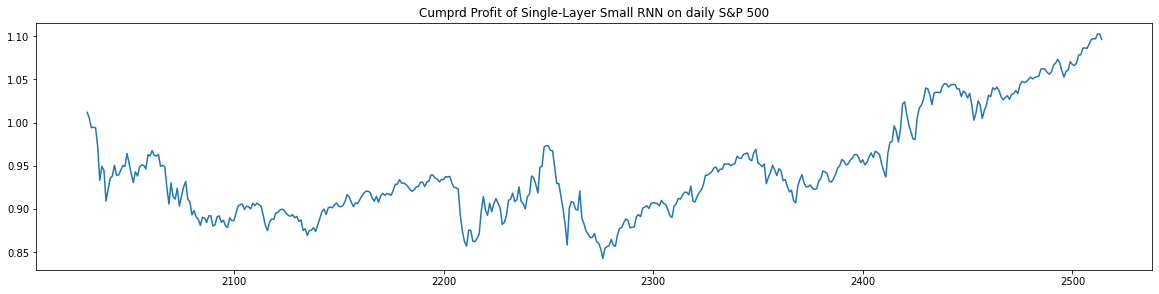

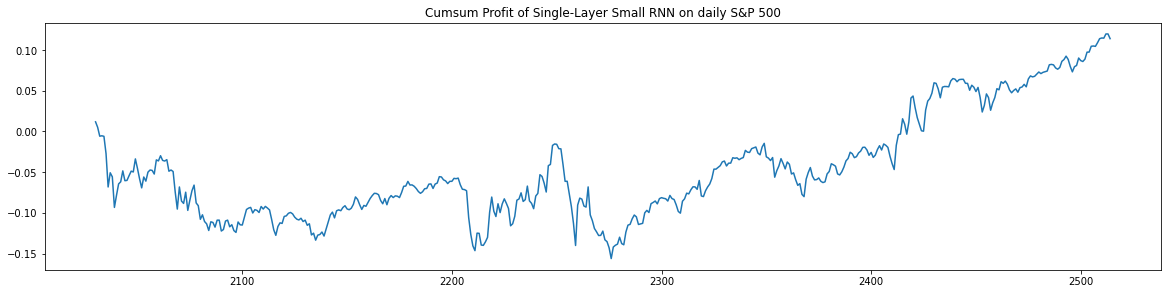

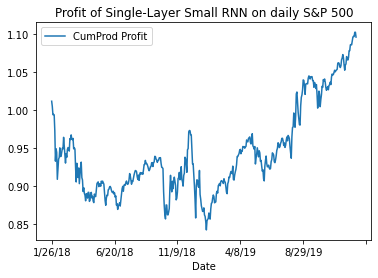

In [74]:
date = df.iloc[2030:, :]['Date']
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=single_layer_small_rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of single layer small rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of single layer small rnn:', cumsprofit)
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Single-Layer Small RNN on daily S&P 500')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Single-Layer Small RNN on daily S&P 500')
plt.show()
profit_df = pd.DataFrame(columns=['Date', 'profit'])
profit_df['Date'] = date
profit_df['CumProd Profit'] = cumpprofit.values
profit_df.plot(x = 'Date', y = 'CumProd Profit', title = 'Profit of Single-Layer Small RNN on daily S&P 500')
plt.show()

cumproduct profit of single layer rnn: 2030    1.011841
2031    1.005030
2032    0.994076
2033    0.994562
2034    0.993917
          ...   
2510    1.072841
2511    1.072631
2512    1.078132
2513    1.078168
2514    1.071936
Name: short, Length: 485, dtype: float64
cumsum profit of single layer rnn: 2030    0.011841
2031    0.005109
2032   -0.005790
2033   -0.005301
2034   -0.005949
          ...   
2510    0.092314
2511    0.092119
2512    0.097247
2513    0.097281
2514    0.091500
Name: short, Length: 485, dtype: float64


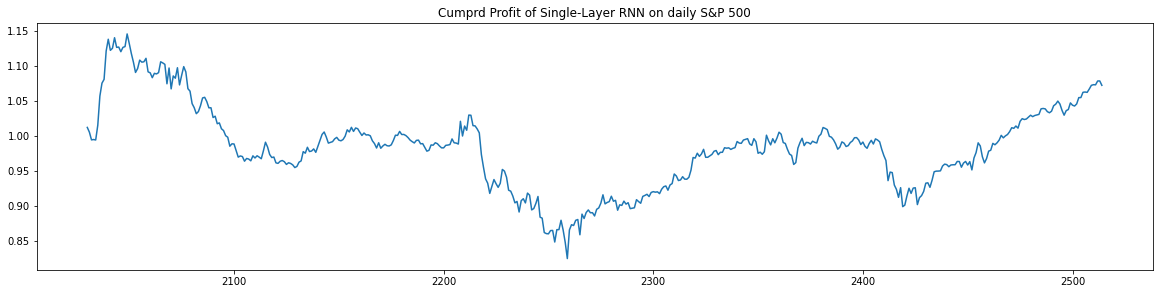

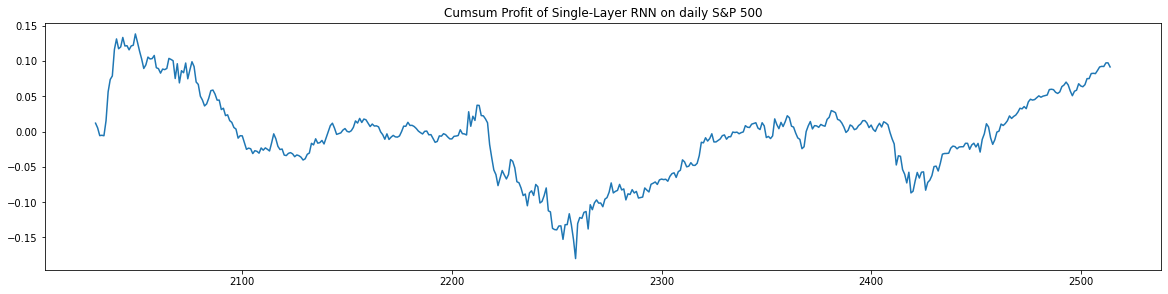

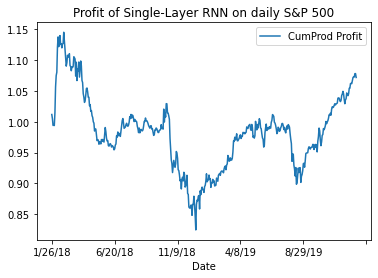

In [75]:
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=single_layer_rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of single layer rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of single layer rnn:', cumsprofit)

fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Single-Layer RNN on daily S&P 500')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Single-Layer RNN on daily S&P 500')
plt.show()
profit_df = pd.DataFrame(columns=['Date', 'profit'])
profit_df['Date'] = date
profit_df['CumProd Profit'] = cumpprofit.values
profit_df.plot(x = 'Date', y = 'CumProd Profit', title = 'Profit of Single-Layer RNN on daily S&P 500')
plt.show()

cumproduct profit of multi layer rnn: 2030    1.011841
2031    1.005030
2032    0.994076
2033    0.993590
2034    0.992946
          ...   
2510    1.236653
2511    1.236411
2512    1.242752
2513    1.242794
2514    1.235610
Name: short, Length: 485, dtype: float64
cumsum profit of multi layer rnn: 2030    0.011841
2031    0.005109
2032   -0.005790
2033   -0.006279
2034   -0.006927
          ...   
2510    0.234458
2511    0.234262
2512    0.239391
2513    0.239425
2514    0.233644
Name: short, Length: 485, dtype: float64


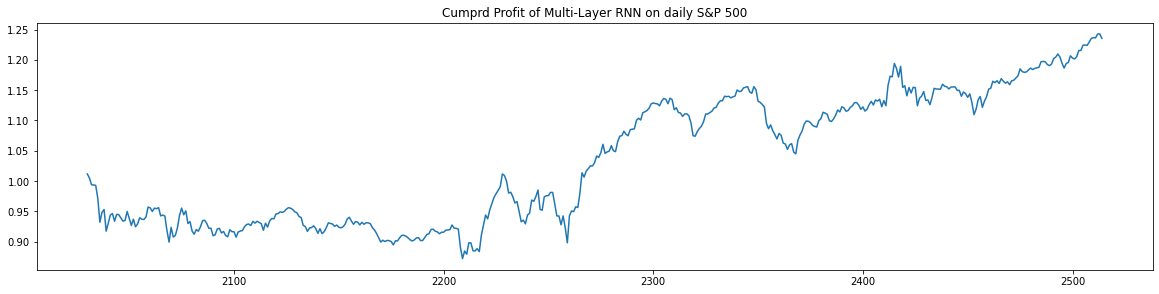

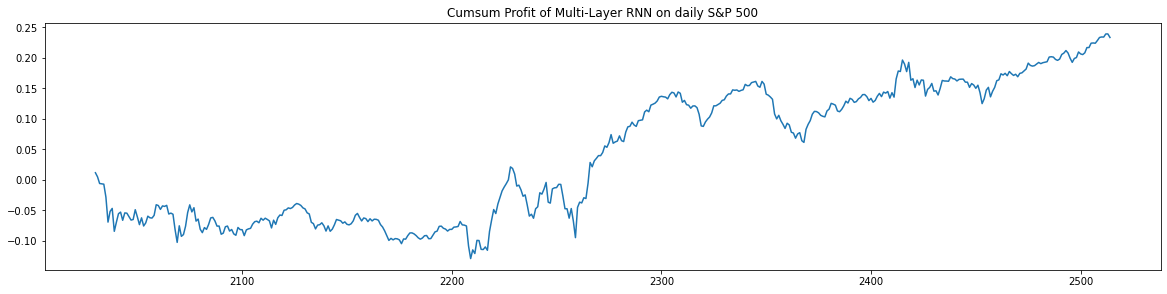

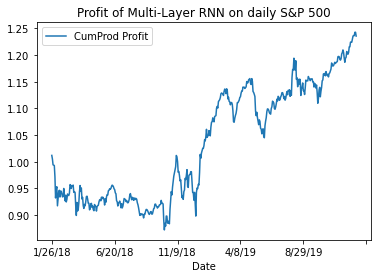

In [77]:
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of multi layer rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of multi layer rnn:', cumsprofit)

fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Multi-Layer RNN on daily S&P 500')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Multi-Layer RNN on daily S&P 500')
plt.show()
profit_df = pd.DataFrame(columns=['Date', 'profit'])
profit_df['Date'] = date
profit_df['CumProd Profit'] = cumpprofit.values
profit_df.plot(x = 'Date', y = 'CumProd Profit', title = 'Profit of Multi-Layer RNN on daily S&P 500')
plt.show()

In [39]:
marketcump=(ret+1).cumprod()
marketcump

2030    1.011841
2031    1.005030
2032    0.994076
2033    0.994562
2034    0.993917
          ...   
2510    1.135515
2511    1.135293
2512    1.141115
2513    1.141153
2514    1.134557
Name: return, Length: 485, dtype: float64

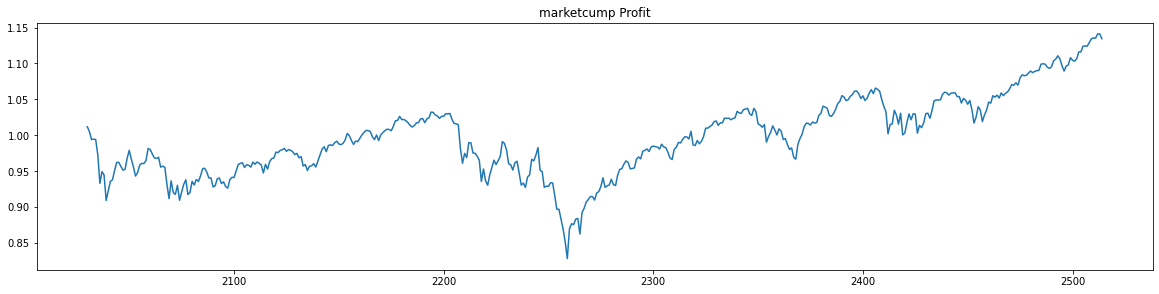

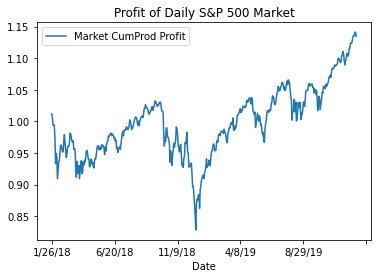

In [79]:
fig = plt.figure(figsize=(20,10))
ax3 = fig.add_subplot(2,1,1)
ax3.plot(marketcump)
ax3.set_title('marketcump Profit')
plt.show()

mkt_df = pd.DataFrame(columns=['Date', 'Market CumProd Profit'])
mkt_df['Date'] = date
profit_df['Market CumProd Profit'] = marketcump.values
profit_df.plot(x = 'Date', y = 'Market CumProd Profit', title = 'Profit of Daily S&P 500 Market')
plt.show()

In [41]:
marketcums=ret.cumsum()
marketcums

2030    0.011841
2031    0.005109
2032   -0.005790
2033   -0.005301
2034   -0.005949
          ...   
2510    0.149191
2511    0.148996
2512    0.154124
2513    0.154158
2514    0.148377
Name: return, Length: 485, dtype: float64

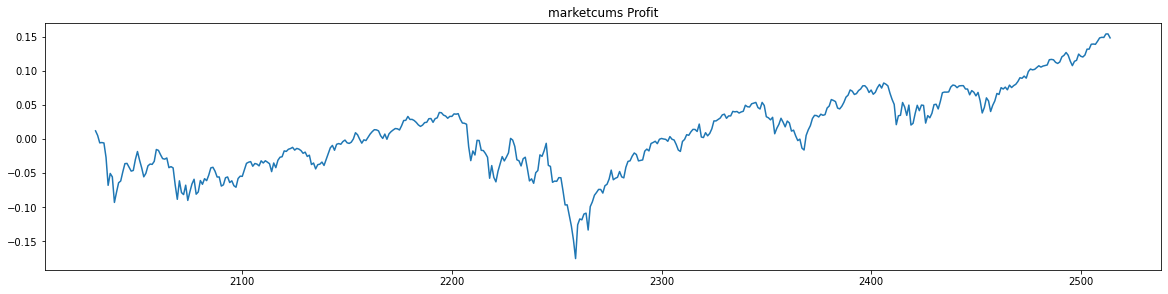

In [42]:
fig = plt.figure(figsize=(20,10))
ax2 = fig.add_subplot(2,1,1)
ax2.plot(marketcums)
ax2.set_title('marketcums Profit')
plt.show()